# Introduction

The 'Electrical Grid Stability Simulated Data' is a dataset retrieved from the UCI Machine Learning Repository. This dataset is part of a paper published in an IEEE conference on a Decentral Smart Grid Control system used for remote real-time monitoring of electrical grid stability and tracking of power consumption. 

In [1]:
# load all necessary libraries and set matplotlib magic command
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC, l1_min_c
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_selection import RFECV
from matplotlib.pyplot import cm

import math
import scipy.stats as stats
from scipy.stats import anderson

plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Exploratory Data Analysis

In [2]:
# read the UCI electrical grid csv dataset
uci_df = pd.read_csv("dataset/Data_for_UCI_named.csv")

It consists of 12 feature or explanatory variables, which are continuous values and 2 response or dependent variables. The response variable can either be a continuous value or a categorical variable which describes the stability of the electrical grid based on the explanatory variables. 

From the table below, we can see the feature and response variables provided by the dataset.

1. **tau[x]**: reaction time of participant (real from the range 0.5s to 10s). tau1 is the value for electricity producer.
2. **p[x]**: nominal power consumed(negative)/produced(positive)(real). p1 = abs(p2 + p3 + p4)
3. **g[x]**: coefficient (gamma) proportional to price elasticity (real from the range [0.05, 1]s^-1). g1 is the value for electricity producer.
4. **stab**: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
5. **stabf**: the stability label of the system (categorical: stable/unstable)

In [3]:
uci_df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [4]:
# Check for duplicated rows
uci_df.duplicated().sum()

0

There is some class imbalance in the dataset, as the number of `unstable` instances is nearly twice as many as `stable` classes.

In [5]:
print(uci_df.stabf.value_counts())

unstable    6380
stable      3620
Name: stabf, dtype: int64


Using a correlation plot, we can check for any highly-correlated features that we may have to prune. It looks like the features are mostly uncorrelated, with the highest negative correlation being around -0.58. Hence, we do not need to drop any features at this stage.

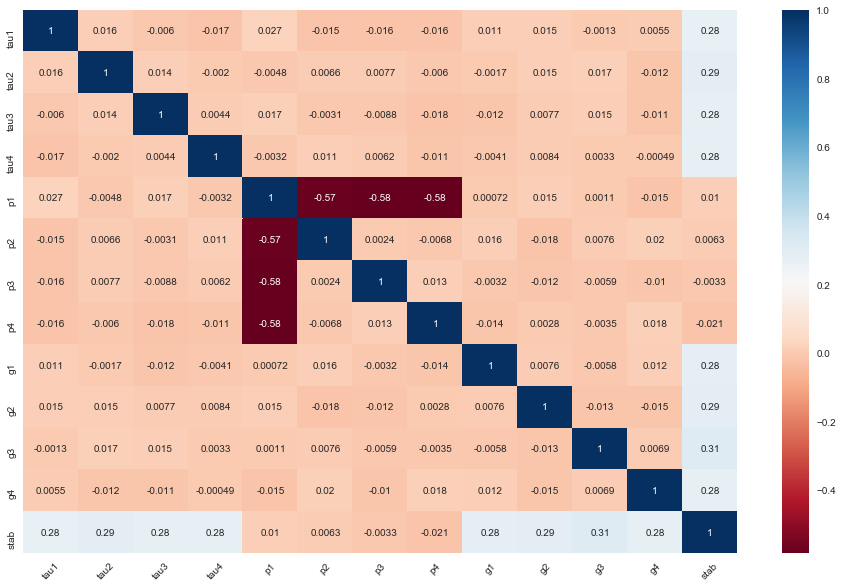

In [6]:
# Correlation heatmap for picked features (Entire Dataset)
plt.figure(figsize=(16,10))
heatmap = sns.heatmap(uci_df.corr(), annot = True,  cmap="RdBu")
plt.xticks(rotation=45)
heatmap.set_ylim(len(uci_df.corr()), 0);

In [7]:
# Exploratory data analysis for entire dataset with pandas profiler
pp.ProfileReport(uci_df)

We set the explanatory and response variables at this step. Since we are doing classification, we will drop the two response variables and keep the rest of the features. The categorical response variable `stabf` will be used as our target. Thus, our models will be predicting whether a grid with a given set of features is either stable or unstable.

In [8]:
X = uci_df.drop(['stab', 'stabf'], axis=1)  # set the explanatory variables
y = uci_df[['stabf']]                       # set the response variable

**Yeo-Johnson Power Transformation**

Normalisation is first done with a Yeo-Johnson Power Transformation, which is a statistical transformation to transform non-normal dependent variables into a normal shape, as normality is an important assumption for many statistical techniques. It can help us with addressing heteroskedasticity or non-normal distributions, stabilising variance and skewness, thus improving the Pearson correlation between variables and generally stabilises the data.

Normalisation is useful when the data has varying scales and the algorithm used does not make assumptions about the distribution of the data, such as k-nearest neighbours and artificial neural networks. This helps to improve the model performance.

In scikit-learn, the PowerTransformer() method can be used to implement a Yeo-Johnson power transformation on our dataset.



In [9]:
pt = PowerTransformer()
pt.fit(X)
X_pt = pd.DataFrame(pt.transform(X))
X_pt.columns = X.columns
X_pt.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,-0.800609,-0.752403,1.115417,1.555914,0.019129,1.081616,-0.041466,-1.086350,0.474201,1.208018,1.304195,1.546246
1,1.407671,-0.063529,-0.765272,-1.477631,1.748552,-1.557544,-1.412319,-0.035988,-0.386470,1.217822,0.157372,0.937500
2,1.303245,1.264286,-0.765695,-1.549058,-0.456999,0.073651,-0.086964,0.748457,-1.336323,0.884767,1.138302,-1.544441
3,-1.788332,0.885083,-0.215187,-1.053688,0.285773,0.494112,-1.555148,0.565323,-0.265438,1.610034,1.448261,-0.575221
4,-0.730889,0.865166,-0.048648,1.579645,-0.296411,0.263926,-1.354336,1.647923,0.991089,-0.231434,0.497312,1.074006


# Feature Selection using Recursive Feature Elimination

Recursive Feature Elimination (RFE), is basically a backward elimination of the features. RFE first builds a model on the entire set of features and computes an importance score for each feature. The least important features or weights are then removed, and the model is rebuilt. The importance scores are recalculated, and this process goes on for each iteration until the accuracy decreases.

We will fit a random forest classifier for this implementation of RFE and use a 10-fold cross validattion for each iteration to perform feature selection. Backward selection is usually used with random forests as they tend not to exclude variables from the prediction equation and has an internal method to rank feature importance. (https://bookdown.org/max/FES/recursive-feature-elimination.html)



In [10]:
rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rfc, step=1, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
rfecv.fit(X_pt, y)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


RFECV(cv=10,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=1)

In [11]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 8


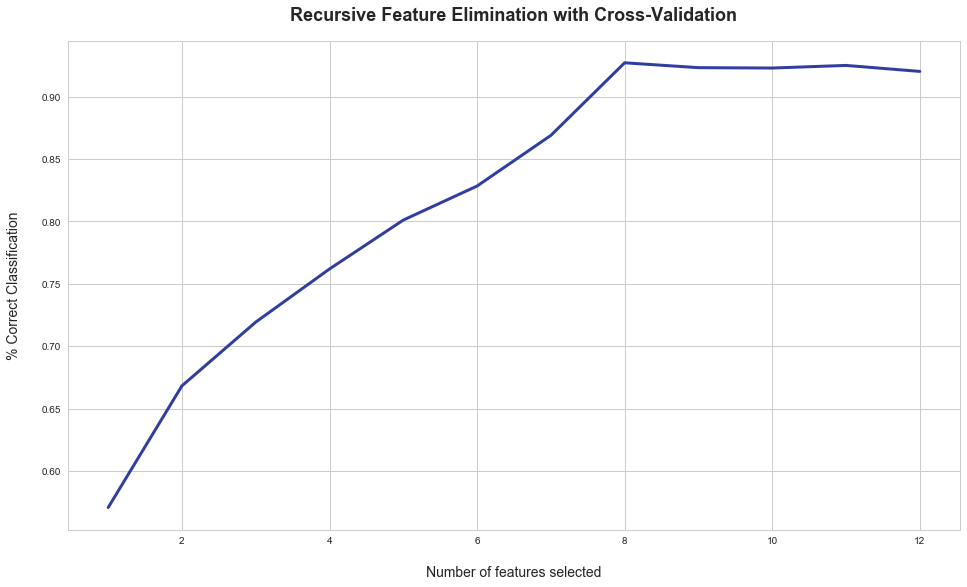

In [12]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

The optimal number of features is 8 after RFE, and the selected features are given below.

In [13]:
# Chosen Features
for i in np.where(rfecv.support_ == True)[0]:
    print(X.columns[i], end=', ')

tau1, tau2, tau3, tau4, g1, g2, g3, g4, 

In [14]:
X_pt_dropped = X_pt.drop(X_pt.columns[np.where(rfecv.support_ == False)[0]], axis=1)

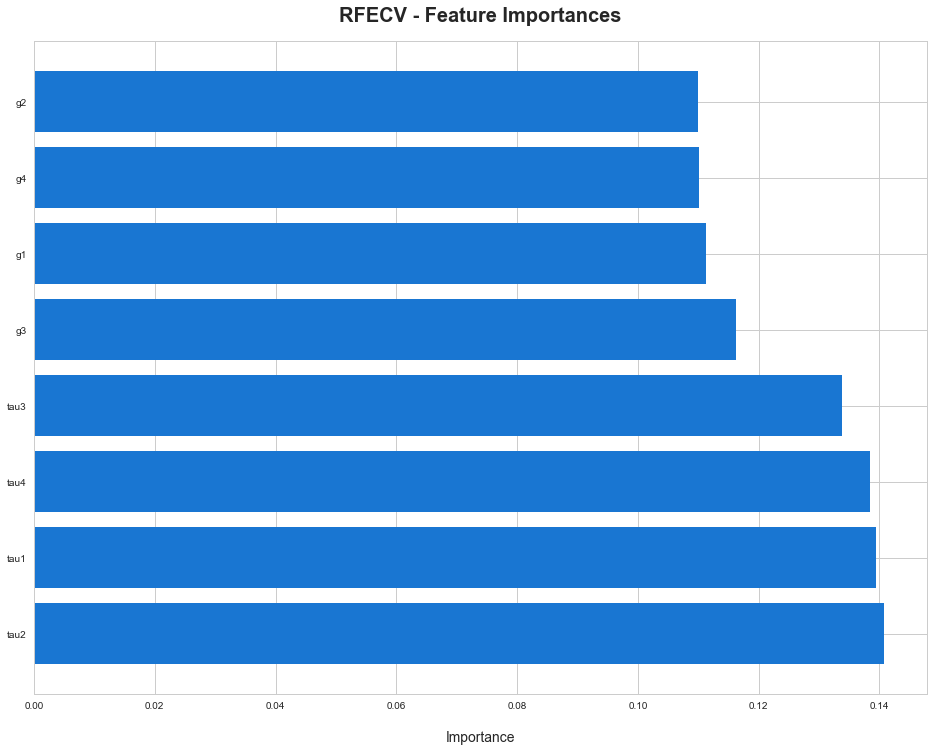

In [15]:
dset = pd.DataFrame()
dset['attr'] = X_pt_dropped.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 12))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

We can plot out the importance for each selected feature as well.

In [16]:
dset.transpose()

,1,0,3,2,6,4,7,5
attr,tau2,tau1,tau4,tau3,g3,g1,g4,g2
importance,0.140801,0.139383,0.138445,0.133782,0.116298,0.111223,0.110135,0.109934


# Feature Selection using L1-Regularised Logistic Regression

Regularisation is the adding of a penalty term to the coefficients of a model to reduce the freedom of the model and avoid overfitting, improving its general performance on other unseen data. L1 regularisation or lasso can shrink the coefficients of the model to zero depending on the regularisation parameter. Thus, we can use this ability to perform feature selection. The model that overfits the least is the best choice for predictive power.

By adjusting the regularisation parameter C, we can study the effect of the regularisation penalty as C becomes stronger. Over the range of C values, the accuracy of the model can be plotted to derive the best selected coefficients and their corresponding value where the accuracy of the L1-regularised logistic regression is maximised, just like regression where we find the best penalty term and coefficients that maximises the mean-squared-error.

In [17]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_pt, y, test_size=0.2, random_state=42)

Since the regularisation penalty is made up of the sum of the absolute value of the coefficients, we need to scale the data so that the coefficients are all based on the same scale. This helps when the data has large differences between their ranges. Standardisation is also useful when the data has varying scales and the algorithm we are using does make assumptions about your data having a Gaussian distribution.

In [18]:
scaler = StandardScaler()
scaler.fit(X_train_log)  # fit only on training data
X_train_log = scaler.transform(X_train_log)
X_test_log = scaler.transform(X_test_log)  # apply same transformation to test data

By adjusting the regularisation parameter (`C` in the case for the code), we can study the effect of the regularisation penalty as `C` becomes stronger. Over the range of `C` values, the accuracy of the model can be plotted to derive the best selected coefficients and their corresponding value where the accuracy of the L1-regularised logistic regression is maximised. This is similar to regression where we find the best penalty term and coefficients that maximises the mean-squared-error.

Computing regularization path ...
This took 3.682s


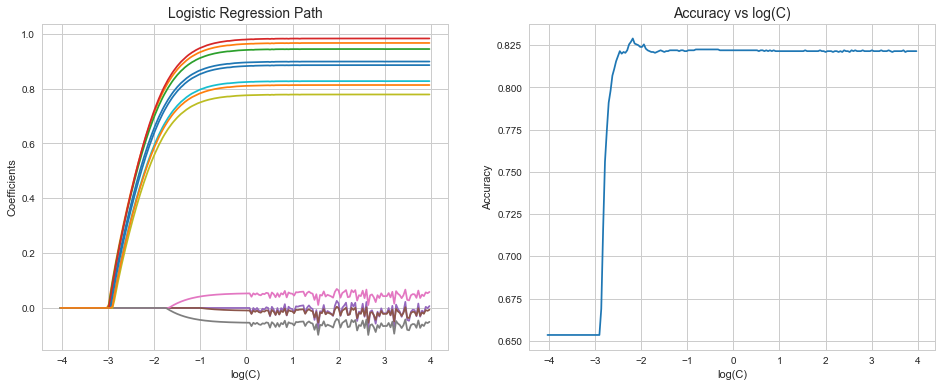

In [19]:
cs = l1_min_c(X_train_log, y_train_log.values.ravel(), loss='log') * np.logspace(-1, 7, 200)

print("Computing regularization path ...")
start = time()
clf = LogisticRegression(penalty='l1', 
                         solver='liblinear', 
                         tol=1e-6, max_iter=int(1e6), 
                         warm_start=True, 
                         intercept_scaling=10000)
coefs_ = []
accs = []
intercepts =[]
for c in cs:
    clf.set_params(C=c)
    clf.fit(X_train_log, y_train_log.values.ravel())
    accs.append(clf.score(X_test_log, y_test_log))
    coefs_.append(clf.coef_.ravel().copy())
    intercepts.append(clf.intercept_.ravel())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
accs = np.array(accs)
intercepts = np.array(intercepts)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path', fontsize=14)
plt.axis('tight')

plt.subplot(122)
plt.plot(np.log10(cs), accs)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs log(C)', fontsize=14)
plt.axis('tight')
plt.show()

In [20]:
print("The optimal C value is {:0.7f} for an accuracy of {:0.3f}".format(cs[np.argmax(accs)], accs.max()))

The optimal C value is 0.0065864 for an accuracy of 0.829


From the maximum accuracy value, we can pick out the best regularisation parameter and the corresponding coefficients for the selected features.

In [21]:
# Intercept for logistic regression
intercepts[np.argmax(accs)][0]

0.8022678591736239

In [22]:
# Values for s
coefs = pd.DataFrame(coefs_[np.argmax(accs)])
coefs.index = list(X_pt.columns)
coefs.transpose()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,0.571104,0.624027,0.610118,0.627076,0.0,0.0,0.0,0.0,0.477709,0.510595,0.552104,0.503647


The features selected by both L1-regularised logistic regression and RFE are the same. `tau` values, which represent reaction time and `g` values, which represent price elasticity are selected to be more important for our model while `p` values, which represent power consumption are set to 0 and dropped. Hence, feature selection can simplify a model and improve generalisation.

$$
\log{\left(\frac{\hat{p}}{1-\hat{p}}\right)}=0.802+0.571\tau_1+0.624\tau_2+0.610\tau_3+0.627\tau_4+0.478g_1+0.511g_2+0.552g_3+0.504g_4
$$

$$
\hat{p}\geq0.5,\ Y=stable;\ \hat{p}<0.5,\ Y=unstable
$$

In [23]:
X_pt.drop(X_pt.columns[np.where(coefs == 0)[0]], axis=1, inplace=True)   # Power Transformed Features
X.drop(X.columns[np.where(coefs == 0)[0]], axis=1, inplace=True)         # No Power Transformation

# Classification Model Building and Comparison

After our feature engineering steps are completed, we can fit the selected features on different machine learning models to determine which model classifies the best with our dataset. For this section, **k-nearest neighbours (kNN)** and **Support Vector Machines (SVM)** has been picked for comparison, since both relies on distance-based methods for classification.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pt, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 8) (8000, 1)
(2000, 8) (2000, 1)


As previously explained, we need to standardise our data to prevent features with wide ranges from dominating the distance metric. This is useful in helping to improve the performance in distance-based learning models, such as our chosen k-nearest neighbours and SVM models. (https://builtin.com/data-science/when-and-why-standardize-your-data)

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)  # fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

### Decision Tree Baseline Performance

The dataset is also based on a relevant paper 'Towards Concise Models of Grid Stability' published in the IEEE Internation Conference, which utilises a CART-based decision tree approach for classification. Although the decision tree model is built here, we will be focusing on our chosen k-nearest neighbours and SVM models, while using decision tree as a baseline for the performance.

In [26]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
y_pred = dtree.predict(X_test)

In [28]:
print("Decision Tree Accuracy: {:0.2f}%".format((accuracy_score(y_test, dtree.predict(X_test))*100)))

Decision Tree Accuracy: 85.10%


The untuned decision tree model achieves a performance accuracy of 85%, which is in-line with the paper's reported performance of around 80%.

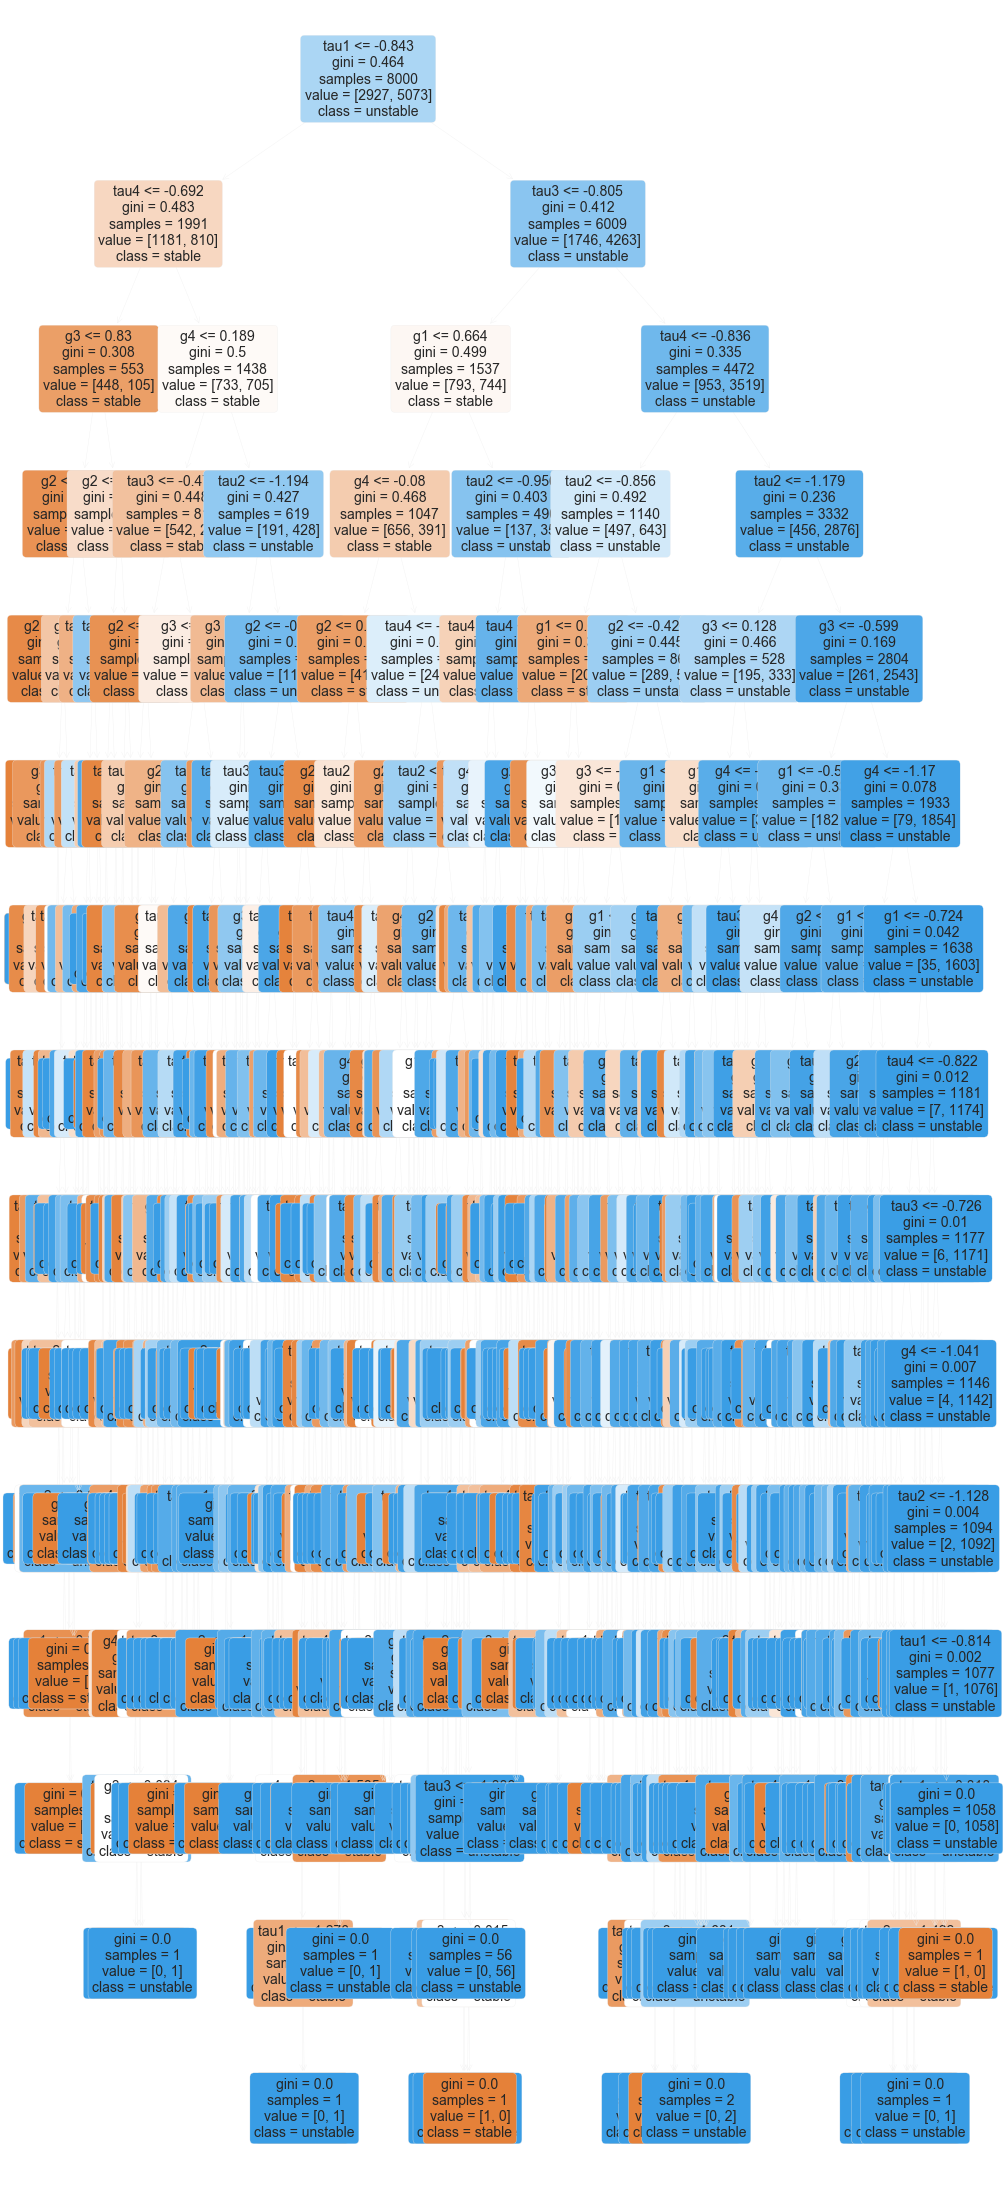

In [29]:
plt.figure(figsize=(16,40))
a = plot_tree(dtree,  
              feature_names = list(X_pt.columns),
              class_names = ['stable', 'unstable'],
              filled=True, 
              rounded=True, 
              fontsize=14)

### k-Nearest Neighbours 

The kNN technique is a simple and intuitive method that is based on closest distance, where a new observation is placed into the class of the observation from the learning set that is closest to the new observation. Being non-parametric, there is no assumption given for the underlying distribution of data, and thus it is memory-based where the model structure is determined from the dataset. kNN is therefore useful for a classification study when there is little or no prior knowledge about the distribution of the data.

The kNN algorithm can be computationally expensive. This is because the model stores all the values of the distances between neighbours in memory and scans the entire range of stored distances each time a prediction is required, resulting in high resource usage and computation time. However, kNN is also a lazy algorithm since it does not use training data to perform generalisation. This makes kNN very fast in the training phase, but keeps all the training data for testing, which can impact testing time.

Classification using kNN works by a majority vote of a variable's neighbours, and this object will be assigned a class based on the number of its nearest neighbours, which makes `k` a hyperparameter that can be tuned using cross validation. kNN can also be used for regression where is output is the predicted continuous value. This value will be the average of its nearest neighbours. (https://blog.usejournal.com/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
print("KNN Accuracy: {:0.2f}%".format((accuracy_score(y_test, knn.predict(X_test))*100)))

KNN Accuracy: 89.05%


By fitting a kNN model with the default instantiations in scikit-learn, the untuned model achieves an accuracy of 89%, which is higher than the baseline decision tree model. We can further perform a 10-fold cross validation on the number of neighbours to determine the optimal `k`value.

In [32]:
# creating odd list of K for KNN
neighbors = list(range(1, 25, 1))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
    cv_scores.append(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parall

The optimal number of neighbors is 14


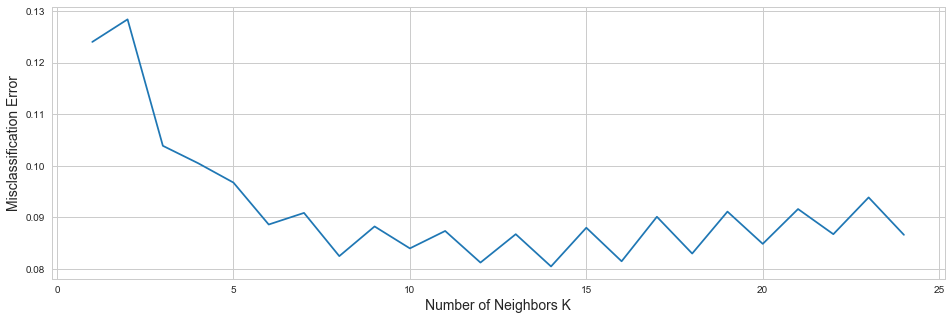

In [33]:
# changing to misclassification error
mis = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mis.index(min(mis))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.figure(figsize=(16,5))
plt.plot(neighbors, mis)
plt.xlabel("Number of Neighbors K", fontsize=14)
plt.ylabel("Misclassification Error", fontsize=14)
plt.show()

After performing cross validation on a range of `k` values, we have determined the best `k`is 14.

### Support Vector Machine

The SVM algorithm aims to find a hyperplane in an N-dimensional space, where N is the number of features we will use in the model. Such a hyperplane will separate the two classes in the response variable and will distinctly classify our data points. There are many possible hyperplanes that can be chosen, but we want to find the optimal hyperplane that has the maximum margin, which is the maximum distance between data points of both classes. By maximising the margin distance, future unseen data points can be classified with more confidence.

![alt text](https://miro.medium.com/max/600/0*0o8xIA4k3gXUDCFU.png)

Support vectors are data points that near the hyperplane that influence the position and orientation of the hyperplane. Using these support vectors, the margin of the SVM model can be maximised. Removing the support vectors will change the position of the hyperplane.

Since SVMs attempt to maximise the margin of the hyperplanes to the clusters, they require a kernel to tackle non-linear problems. Otherwise, the SVM hyperplanes would be strictly linear. As SVM does not require vectors to work, we can use the dot products between them instead. Hence, using the kernel trick we can get a non-linear classifier without transforming the data.

The regularisation parameter `C` is added to the cost function of SVM to balance the margin maximisation and loss. This can be tuned with cross validation. Another tunable parameter is the `gamma`, which defines the reach of a training data point. With low gamma, points further away from the hyperplane will be considered. High gamma will only consider points near to the hyperplane.

![alt text](https://miro.medium.com/max/1200/1*ClmsnU_yb1YtIwAAr7krmg.png)

In [34]:
svc_rbf = SVC(kernel='rbf')
svc_lin = SVC(kernel='linear') 
svc_pol = SVC(kernel='poly') 
svc_sig = SVC(kernel='sigmoid') 

We will first fit four SVMs with different kernels to consider their performance.

In [35]:
svc_rbf.fit(X_train, y_train)
svc_lin.fit(X_train, y_train)
svc_pol.fit(X_train, y_train)
svc_sig.fit(X_train, y_train);

In [36]:
print("SVC (RBF) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_rbf.predict(X_test))*100)))
print("SVC (Linear) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_lin.predict(X_test))*100)))
print("SVC (Poly) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_pol.predict(X_test))*100)))
print("SVC (Sigmoid) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_sig.predict(X_test))*100)))

SVC (RBF) Accuracy: 96.75%
SVC (Linear) Accuracy: 82.20%
SVC (Poly) Accuracy: 90.85%
SVC (Sigmoid) Accuracy: 72.00%


From the above results, it looks like the SVM with a RBF kernel achieved the best accuracy. We can visualise the decision hyperplane below by using PCA to decompose our feature space to two dimensions for plotting.

In [37]:
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)

In [38]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

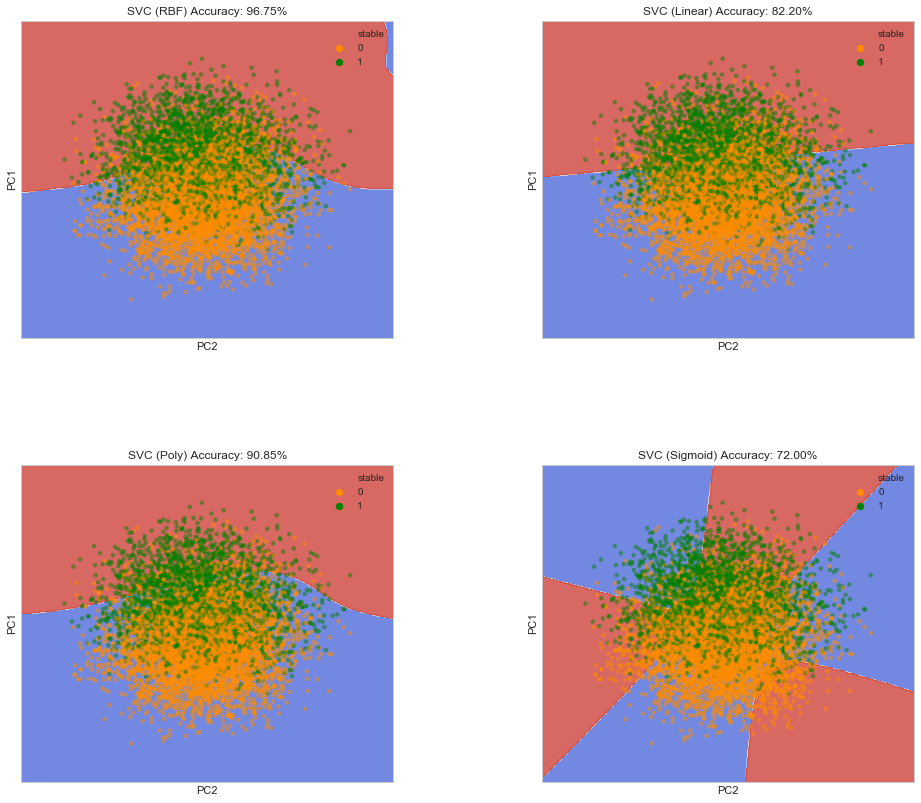

In [39]:
h = .02  # step size in the mesh

# title for the plots
titles = ["SVC (RBF) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_rbf.predict(X_test))*100)), 
          "SVC (Linear) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_lin.predict(X_test))*100)), 
          "SVC (Poly) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_pol.predict(X_test))*100)), 
          "SVC (Sigmoid) Accuracy: {:0.2f}%".format((accuracy_score(y_test, svc_sig.predict(X_test))*100))]

y_train_ohe = pd.get_dummies(y_train.stabf).stable
clf_r = svc_rbf.fit(X_train_2d, y_train_ohe)
clf_l = svc_lin.fit(X_train_2d, y_train_ohe)
clf_p = svc_pol.fit(X_train_2d, y_train_ohe)
clf_s = svc_sig.fit(X_train_2d, y_train_ohe)

# create a mesh to plot in
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

plt.figure(figsize=(16, 14))
for i, clf in enumerate((clf_r, clf_l, clf_p, clf_s)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    sns.scatterplot(X_train_2d[:, 0], X_train_2d[:, 1], hue=y_train_ohe, marker="o", palette=['darkorange', 'green'], s=20, linewidth=0, alpha=0.5)
    plt.xlabel('PC2')
    plt.ylabel('PC1')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

Looking at the four plots for each of the kernels, the RBF kernel is able to fit the non-linear nature of the data points in the best way by adapting the curvature of the hyperplane separating the data points into the two classes.

We can further tune the performance by performing a 10-fold cross validation for both the `C` and `gamma` hyperparameters.

In [40]:
param_dict={'C': np.arange(10, 11, 0.01), 
            'gamma': np.arange(0.1, 0.2, 0.01)} 

svc_grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid=param_dict, n_jobs=-1, cv=10, verbose=1)
svm_tuned = svc_grid.fit(X_train, y_train) 

y_pred_svm_tuned = svm_tuned.predict(X_test)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 7152 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 8402 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

Although we have tuned for the best hyperparameters, the performance only improved marginally from 96.75% to 97.25%. It seems that for SVM in the case of our dataset, the deciding factor on model performance is the type of kernel chosen. This is important as the kernel directly affects the shaper of the hyperplane, and it is vital to choose the kernel that can provide the best fit especially with real-life non-linear data.

In [41]:
svc_grid.best_params_

{'C': 10.699999999999985, 'gamma': 0.1}

### Comparison Between Tuned kNN and SVM models

For both the tuned kNN and SVM models, the following metrics are calculated in scikit-learn’s classification report:
* **Precision**, which indicates how many relevant items were identified: 
$$
Precision = \frac{TP}{TP+FP}
$$
* **Recall**, the percentage of total relevant results that are correctly classified: 
$$
Recall = \frac{TP}{TP+FN}
$$
* **F1-Score** combines the precision and recall to give a single score, is defined to be the harmonic mean of the precision and recall: 
$$
F1-Score = \frac{2 × Precision × Recall}{Precision + Recall}
$$

The tuned SVM model generally performs better than the tuned kNN model since it has a higher accuracy of 97% against kNN’s 91% accuracy. While kNN can classify ‘unstable’ labels reasonably well as it has a high recall score of 0.95, it struggles in classifying ‘stable’ labels with a recall score of 0.85. SVM can classify much better than kNN for both classes as its recall value beats kNN in both classes. This observation is also reflected in the confusion matrix where SVM achieves a low misclassification error in the 20s range for both classes while kNN has a much greater number of misclassified labels (71 and 107 respectively).

Both SVM and kNN were able to beat decision tree even in their untuned state, which makes them better candidates for detecting electrical grid stability. This observation is also reflected in the dataset’s paper, though the author chose to use decision tree instead to study the decision splitting at each node for the different features.


In [42]:
knn_tuned = KNeighborsClassifier(n_neighbors=optimal_k).fit(X_train, y_train)
print("Accuracy of K-Nearest Neighbours model after tuning for optimal number of neighbours k: {}% \n".format(
    (accuracy_score(y_test, knn_tuned.predict(X_test))*100).round(2)))
print(classification_report(y_test, knn_tuned.predict(X_test)))

Accuracy of K-Nearest Neighbours model after tuning for optimal number of neighbours k: 91.1% 

              precision    recall  f1-score   support

      stable       0.89      0.85      0.87       693
    unstable       0.92      0.95      0.93      1307

    accuracy                           0.91      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.91      0.91      2000



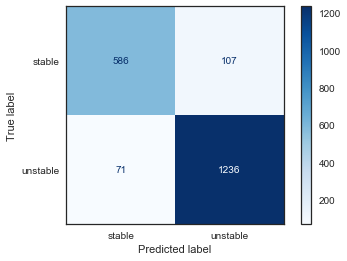

In [43]:
plt.style.use('seaborn-white')
plot_confusion_matrix(knn_tuned, X_test, y_test, values_format = 'd', cmap='Blues');

In [44]:
print("Accuracy of SVC (RBF) model after grid search: {:0.2f}% \n".format((accuracy_score(y_test, y_pred_svm_tuned)*100)))
print(classification_report(y_test, y_pred_svm_tuned))

Accuracy of SVC (RBF) model after grid search: 97.25% 

              precision    recall  f1-score   support

      stable       0.96      0.96      0.96       693
    unstable       0.98      0.98      0.98      1307

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



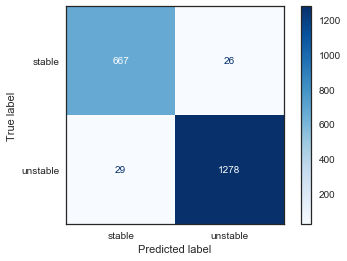

In [45]:
plt.style.use('seaborn-white')
plot_confusion_matrix(svm_tuned, X_test, y_test, values_format = 'd', cmap='Blues');

Likewise, the AUC for the ROC curve for SVM is 0.998 which is higher than that of kNN, which is 0.974. Despite the class imbalance mentioned earlier, both models managed to classify the labels reasonably well.

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs_knn = knn_tuned.predict_proba(X_test)
probs_knn = probs_knn[:, 1]

probs_svm = svm_tuned.predict_proba(X_test)
probs_svm = probs_svm[:, 1]

y_test_ohe = pd.get_dummies(y_test.stabf).stable
fprk, tprk, thresholds = roc_curve(y_test_ohe, probs_knn)
fprs, tprs, thresholds = roc_curve(y_test_ohe, probs_svm)

auc_knn = roc_auc_score(y_test, probs_knn)
auc_svm = roc_auc_score(y_test, probs_svm)

In [47]:
print('AUC of kNN: %.5f' % auc_knn)
print('AUC of SVM: %.5f' % auc_svm)

AUC of kNN: 0.97370
AUC of SVM: 0.99791


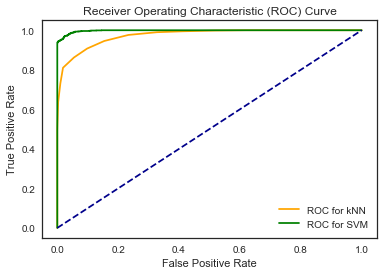

In [48]:
plt.plot(tprk, fprk, color='orange', label='ROC for kNN')
plt.plot(tprs, fprs, color='green', label='ROC for SVM')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()